### PAR-2 RING SEC-MALS (Part 2)

Context:
- SEC-MALS outputs several measures of average molecular weight (here we are using the weight-average measure)
- By using a range of input concentrations, we can build a titration curve which we can fit to a dimer model
- Also overlaying L109R which we measured at a single input concentration

Results:
- Clear evidence for concentration-dependent dimerisation, which fits pretty well to a dimer model

Dependencies:
- Requires _mass_measurements_titration.csv_ and _mass_measurements_L109R.csv_, both generated by _XmlExtract.ipynb_

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from src import fake_log, lighten, nb_setup

nb_setup()
os.makedirs("Figs", exist_ok=True)

%matplotlib inline

In [2]:
# Import wild type data
res = pd.read_csv("mass_measurements_titration.csv")
res_mw = res[res["measurement_type"] == "Mw"]

# Import mutant data
res_L109R = pd.read_csv("mass_measurements_L109R.csv")
res_L109R_mw = res_L109R[res_L109R["measurement_type"] == "Mw"]

# Monomer weight (global variable)
monomer_weight = 9.23474

### Dimer model

In [3]:
def monomer(tot, wd):
    # Concentration of monomer molecules
    return 0.25 * np.exp(-wd) * (np.sqrt(8 * np.exp(wd) * tot + 1) - 1)


def dimer(tot, wd):
    # Concentration of dimer molecules
    return (tot - monomer(tot, wd)) / 2


def mol_weight(tot, wd, mass=monomer_weight):
    # Weight average molecular weight (Mw)
    mon = monomer(tot, wd)
    dim = dimer(tot, wd)
    return (((mass**2) * mon) + (((2 * mass) ** 2) * dim)) / (
        (mass * mon) + (2 * mass * dim)
    )


def mol_weight_from_fraction(frac, mass=monomer_weight):
    # Mw as a function of fraction in the dimeric state
    mon = 1 - frac
    dim = frac / 2
    return (((mass**2) * mon) + (((2 * mass) ** 2) * dim)) / (
        (mass * mon) + (2 * mass * dim)
    )


# Extract data
x = res_mw["input_concentration"] / 1000
y = res_mw["mass"] / 1000
sigma = 1 / (res_mw["uncertainty"] / 1000)

# Fit model
popt, pcov = curve_fit(
    lambda x, wd: mol_weight(x, wd, mass=9.23474),
    x,
    y,
    sigma=sigma,
    absolute_sigma=False,
)
print(popt[0])

-0.46814259890557874


### Plot: titration curve

In [4]:
def minor_ticks(ax, xrange=[-1, 2]):
    xlim = ax.get_xlim()
    minor_x_ticks = np.array([])
    for i in range(xrange[0], xrange[1]):
        a = np.log10(np.linspace(10**i, 10 ** (i + 1), 10))
        minor_x_ticks = np.append(minor_x_ticks, a)
    ax.set_xticks(minor_x_ticks, minor=True)
    ax.set_xlim(*xlim)

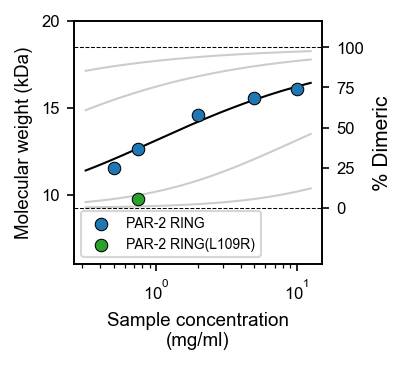

In [5]:
# Set up figure
fig, ax = plt.subplots()
ax2 = ax.twinx()

# Plot model line
xx = np.linspace(-0.5, 1.1, 1000)
ax.plot(xx, mol_weight(10**xx, popt[0]), c="k", zorder=-1, linewidth=1)

# Plot hypothetical model lines
ax.plot(
    xx, mol_weight(10**xx, popt[0] - np.log(10)), c="0.8", zorder=-100, linewidth=1
)
ax.plot(
    xx, mol_weight(10**xx, popt[0] + np.log(10)), c="0.8", zorder=-100, linewidth=1
)
ax.plot(
    xx, mol_weight(10**xx, popt[0] - np.log(100)), c="0.8", zorder=-100, linewidth=1
)
ax.plot(
    xx, mol_weight(10**xx, popt[0] + np.log(100)), c="0.8", zorder=-100, linewidth=1
)

# Plot wild type data
ax.scatter(
    np.log10(res_mw["input_concentration"] / 1000),
    res_mw["mass"] / 1000,
    linewidth=0.5,
    edgecolors="k",
    color=lighten("tab:blue", 1),
)

# Plot mutant data
ax.scatter(
    np.log10(res_L109R_mw["input_concentration"] / 1000),
    res_L109R_mw["mass"] / 1000,
    color=lighten("tab:green", 1),
    linewidth=0.5,
    edgecolors="k",
)

# Left axis
ymin, ymax = 6, 20
ax.set_ylim(ymin, ymax)
ax.set_yticks([10, 15, 20])
ax.set_ylabel("Molecular weight (kDa)", fontsize=9)

# Monomer weight lines
ax.axhline(monomer_weight, c="k", linestyle="--", linewidth=0.5, zorder=0)
ax.axhline(monomer_weight * 2, c="k", linestyle="--", linewidth=0.5, zorder=0)

# Right axis
ax2.set_ylim(ymin, ymax)
ax2.tick_params(axis="y", labelsize=8)
ax2_tick_labels = [0, 25, 50, 75, 100]
ax2.set_yticks([mol_weight_from_fraction(x / 100) for x in ax2_tick_labels])
ax2.set_yticklabels(ax2_tick_labels)
ax2.set_ylabel("% Dimeric")

# Legend
ax.scatter(
    [],
    [],
    linewidth=0.5,
    edgecolors="k",
    color=lighten("tab:blue", 1),
    label="PAR-2 RING",
)
ax.scatter(
    [],
    [],
    linewidth=0.5,
    edgecolors="k",
    color=lighten("tab:green", 1),
    label="PAR-2 RING(L109R)",
)
ax.legend(fontsize=6.7)

# Finalise figure
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("Sample concentration\n(mg/ml)", fontsize=9)
ax.set_xticks([0, 1])
ax.xaxis.set_major_formatter(fake_log)
minor_ticks(ax)
fig.set_size_inches(3, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.25, top=0.9, right=0.8)

# Save
fig.savefig("Figs/titration.png", dpi=600, transparent=True)
fig.savefig("Figs/titration.pdf", transparent=True)

In [6]:
# SourceData
df_figure = (
    pd.concat([res_mw.assign(Genotype="WT"), res_L109R_mw.assign(Genotype="L109R")])
    .drop(columns=["uncertainty", "measurement_type"])
    .rename(
        columns={
            "mass": "Molecular weight (Da)",
            "input_concentration": "Sample concentration (ug/ml)",
        }
    )
)
df_figure.to_csv("../../../data/EMBO_source_data/2H.csv", index=False)